# Bosscha/Zeiss Double Star (BZDS) object query with _Gaia_ eDR3 and finding chart plotter

by : Irfan Imaduddin<br>
date    : 10 June 2021<br>
version : 1.0<br>
contact : irfanimaduddin[at]gmail.com<br><br>

---

### Install necessary modules

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery
    !pip install astropy

### Import the modules

In [2]:
%matplotlib inline               

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Set Timeout


In [3]:
Vizier.TIMEOUT = 1800 # in seconds

### Select the Gaia EDR3 Catalog for Query and Filter the GMag <= 12

In [4]:
wds_query=Vizier(columns=["Source","RAJ2000","DEJ2000","Gmag"], 
                 catalog=["I/350/gaiaedr3"],
                 column_filters={"Gmag":"<=12"})

### Individual Object Query 

In [5]:
objek = 'WDS 12005-1517' # Insert the object name

In [6]:
obj_query = wds_query.query_object(objek)

### Assign Query to DataFrame

In [7]:
obj_querydf = obj_query[0].to_pandas()

### Find the Primary Object

In [8]:
cen_obj = obj_querydf[obj_querydf.Gmag == obj_querydf.Gmag.min()].reset_index(drop=True)
cen_obj_ra = cen_obj.RAJ2000
cen_obj_de = cen_obj.DEJ2000

In [9]:
cen_obj

,Source,RAJ2000,DEJ2000,Gmag
0,3568990799320212224,180.116867,-15.279552,9.654034


### Set Gaia Job

In [10]:
columns = 'source_id, ra, dec, phot_g_mean_mag'

In [11]:
query_base = """SELECT 
{columns}
FROM gaiaedr3.gaia_source
WHERE 
CONTAINS(
	POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
	BOX('ICRS',{cen_obj_ra},{cen_obj_de},1,1)
)=1  AND  (gaiaedr3.gaia_source.phot_g_mean_mag<=12)
"""

### Region Query with the Primary as the Central

In [12]:
gaia_query = query_base.format(columns=columns, cen_obj_ra=str(float(cen_obj_ra)), cen_obj_de=str(float(cen_obj_de)))

In [13]:
job = Gaia.launch_job(gaia_query)

In [14]:
result = job.get_results()

In [15]:
reg_querydf = result.to_pandas()

In [16]:
reg_querydf.head()

,source_id,ra,dec,phot_g_mean_mag
0,3568679328291423616,180.027462,-15.772211,11.562316
1,3568759523920356992,180.354555,-15.736758,11.149019
2,3568763303491611008,180.537537,-15.708255,9.816649
3,3568782338786638208,180.325235,-15.573685,11.933821
4,3568783953694343424,180.354235,-15.527681,9.255332


In [17]:
reg_querydf[reg_querydf.source_id == cen_obj.Source[0]]

,source_id,ra,dec,phot_g_mean_mag
16,3568990799320212224,180.11675,-15.279447,9.654034


### Modify the RA

In [18]:
if (reg_querydf.ra.max()-reg_querydf.ra.min()) > 180.:    
    mod_ra = []
    for i in range(len(reg_querydf.ra)):
        if reg_querydf.ra[i] > 180.:
            mod_ra.append(reg_querydf.ra[i] - 360.)
        else:
            mod_ra.append(reg_querydf.ra[i])
            
    reg_querydf['mod_ra'] = mod_ra

    if cen_obj.RAJ2000[0] > 180.:
        cen_obj['mod_ra'] = cen_obj.RAJ2000[0] - 360.    
    else:
        cen_obj['mod_ra'] = cen_obj.RAJ2000[0]

else:
    reg_querydf['mod_ra'] = reg_querydf.ra
    cen_obj['mod_ra']     = cen_obj.RAJ2000[0]

### Find the Width and Height of the Image

In [19]:
deltacoord = np.sqrt(60*60/2)/60./2. # in degrees

xmin, xmax = float(cen_obj.mod_ra) - deltacoord, float(cen_obj.mod_ra) + deltacoord
ymin, ymax = float(cen_obj.DEJ2000) - deltacoord, float(cen_obj.DEJ2000) + deltacoord

### Group Objects by its GMags

In [20]:
table_6 = reg_querydf[(reg_querydf.phot_g_mean_mag <= 6.)]
table_7 = reg_querydf[(reg_querydf.phot_g_mean_mag > 6.) & (reg_querydf.phot_g_mean_mag <= 7.)]
table_8 = reg_querydf[(reg_querydf.phot_g_mean_mag > 7.) & (reg_querydf.phot_g_mean_mag <= 8.)]
table_9 = reg_querydf[(reg_querydf.phot_g_mean_mag > 8.) & (reg_querydf.phot_g_mean_mag <= 9.)]
table_10 = reg_querydf[(reg_querydf.phot_g_mean_mag > 9.) & (reg_querydf.phot_g_mean_mag <= 10.)]
table_11 = reg_querydf[(reg_querydf.phot_g_mean_mag > 10.) & (reg_querydf.phot_g_mean_mag <= 11.)]
table_12 = reg_querydf[(reg_querydf.phot_g_mean_mag > 11.)]

### Assign Groups to SkyCoord

In [21]:
coord_obj = coord.SkyCoord(cen_obj.mod_ra, cen_obj.DEJ2000, frame="icrs", unit=u.deg)

coord_6 = coord.SkyCoord(table_6.mod_ra, table_6.dec, frame="icrs", unit=u.deg)
coord_7 = coord.SkyCoord(table_7.mod_ra, table_7.dec, frame="icrs", unit=u.deg)
coord_8 = coord.SkyCoord(table_8.mod_ra, table_8.dec, frame="icrs", unit=u.deg)
coord_9 = coord.SkyCoord(table_9.mod_ra, table_9.dec, frame="icrs", unit=u.deg)
coord_10 = coord.SkyCoord(table_10.mod_ra, table_10.dec, frame="icrs", unit=u.deg)
coord_11 = coord.SkyCoord(table_11.mod_ra, table_11.dec, frame="icrs", unit=u.deg)
coord_12 = coord.SkyCoord(table_12.mod_ra, table_12.dec, frame="icrs", unit=u.deg)

### Wrap the RA to Plot it Easily

In [22]:
if (reg_querydf.mod_ra < 0.).any():
  ra_obj = coord_obj.ra.wrap_at(180.*u.degree)

  ra_6 = coord_6.ra.wrap_at(180.*u.degree)
  ra_7 = coord_7.ra.wrap_at(180.*u.degree)
  ra_8 = coord_8.ra.wrap_at(180.*u.degree)
  ra_9 = coord_9.ra.wrap_at(180.*u.degree)
  ra_10 = coord_10.ra.wrap_at(180.*u.degree)
  ra_11 = coord_11.ra.wrap_at(180.*u.degree)
  ra_12 = coord_12.ra.wrap_at(180.*u.degree)
else:
  ra_obj = coord_obj.ra

  ra_6 = coord_6.ra
  ra_7 = coord_7.ra
  ra_8 = coord_8.ra
  ra_9 = coord_9.ra
  ra_10 = coord_10.ra
  ra_11 = coord_11.ra
  ra_12 = coord_12.ra

### Plot the Finding Chart

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

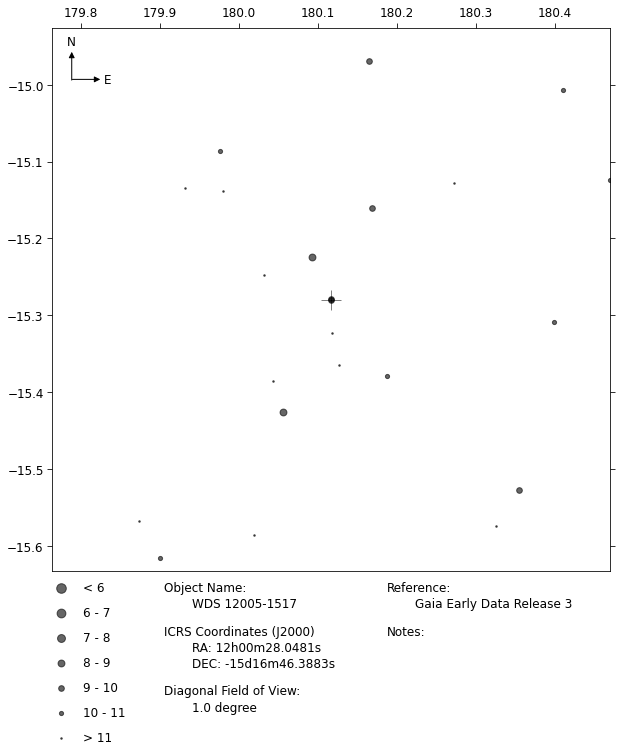

In [25]:
fig, ax = plt.subplots(figsize=(10, 10), frameon=True)
ax.plot(ra_obj, coord_obj.dec, '+', color='black', mew=.5, ms=20.)
ax.scatter(ra_6, coord_6.dec, s=370, marker='.', color='black', alpha=.6, edgecolors=None, label='< 6')
ax.scatter(ra_7, coord_7.dec, s=310, marker='.', color='black', alpha=.6, edgecolors=None, label='6 - 7')
ax.scatter(ra_8, coord_8.dec, s=250, marker='.', color='black', alpha=.6, edgecolors=None, label='7 - 8')
ax.scatter(ra_9, coord_9.dec, s=190, marker='.', color='black', alpha=.6, edgecolors=None, label='8 - 9')
ax.scatter(ra_10, coord_10.dec, s=130, marker='.', color='black', alpha=.6, edgecolors=None, label='9 - 10')
ax.scatter(ra_11, coord_11.dec, s=70, marker='.', color='black', alpha=.6, edgecolors=None, label='10 - 11')
ax.scatter(ra_12, coord_12.dec, s=10, marker='.', color='black', alpha=.6, edgecolors=None, label='> 11')

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.tick_params(labelsize=12., size=5.)
ax.tick_params(top=True, bottom=False, left=True, right=True, labelleft=True, labelright=False, labelbottom=False, labeltop=True)

leg = ax.legend(frameon=False, loc='lower left', fontsize=12., 
                bbox_to_anchor=(-.025, -.3375), labelspacing=1, columnspacing=1.2)

for t in leg.get_texts():
    t.set_ha('left')
    t.set_position((0.,0))

ax.annotate('N', xy=(.035, .9),  xycoords='axes fraction', xytext=(.035, .975), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<|-", facecolor='black'), horizontalalignment='center', verticalalignment='center', fontsize=12.)

ax.annotate('E', xy=(.0325, .905),  xycoords='axes fraction', xytext=(.1, .905), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<|-", facecolor='black'), horizontalalignment='center', verticalalignment='center', fontsize=12.)


ax.text(.20, -.03, 'Object Name:', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.25, -.06, '%s'%(objek), horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.20, -.11, 'ICRS Coordinates (J2000)', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.25, -.14, 'RA: %s'%(coord_obj.ra.to_string(u.hour)[0]), horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.25, -.17, 'DEC: %s'%(coord_obj.dec.to_string(u.degree)[0]), horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.20, -.22, 'Diagonal Field of View:', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.25, -.25, '1.0 degree', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)

ax.text(.60, -.03, 'Reference:', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.65, -.06, 'Gaia Early Data Release 3', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)
ax.text(.60, -.11, 'Notes:', horizontalalignment='left', verticalalignment='center', fontsize=12., transform=ax.transAxes)

# If using local machine, uncomment this code
# plt.savefig(objek+'_back.png', dpi=300., bbox_inches='tight')

# If using Google Colab, uncomment below codes
from google.colab import files
plt.savefig(objek+'_back.png', dpi=300., bbox_inches='tight')
files.download(objek+'_back.png')